In [ ]:
from FADS_SRP.models import supervised_autoencoder, nn, lr
from FADS_SRP.input import get_dsets_
from FADS_SRP.auc import calculate_auc
from FADS_SRP.thresholding import *

import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
from sklearn.svm import SVC
import silence_tensorflow.auto
from pandas import DataFrame


#rho = constant

def get_dset(h2s, sim_i):
    P = f"/home/shussain/Simulated_data/29062021/{h2s}/simulation_output{sim_i}/PS/output/"
    return get_dsets_(P)

path = "/home/shussain/experiments/hapgen2-PS/29062021_20kSNPs/"
with open(f"{path}thresholding.csv", 'w') as t:
    t.writelines("h2s,simulation,k,p_svm,ae_svm,p_lr,ae_lr,p_nn,ae_nn\n")

H2S = [0.05, 0.25, 0.5, 0.75, 1]
K = [5, 25, 100, 300]    

for h2s in H2S:
    print(f"h2s={h2s}")
    for i in trange(1, 6, desc="sim_out"):
        #get dataset
        dset = get_dset(h2s, i)
        #train sae
        hist, ae = supervised_autoencoder(dset["X_train"], dset["y_train"], sizes=[300], 
                                         input_shape=20000, reconstruction_weight=0.3, 
                                         dropout=True, activation="relu", l1=1e-2)
        #generate sum of weights and add it to ct
        dset["ct"] = ae_ct(dset["ct"], ae)        
        
        plt.clf()
        manhattan_plot(dset["ct"])
        plt.savefig(f"{path}/plots/simulation_output{i}/{h2s}/p_manhattan.jpeg")
        plt.clf()
        ae_thresh_plot(dset["ct"])
        plt.savefig(f"{path}plots/simulation_output{i}/{h2s}/ae_manhattan.jpeg")
        plt.close()
        for k in tqdm(K, desc="k"):
            k_p_SNPs_index = get_n_SNPs(dset["ct"], k)
            k_ae_SNPs_index = ae_get_n_SNPs(dset["ct"], k)
            
            #train SVM on p thresholded data
            p_thresh_svm = SVC(probability=True)
            p_thresh_svm.fit(dset["X_train"][:, k_p_SNPs_index], dset["y_train"][:, 1])

            p_thresh_svm_auc = calculate_auc(
                lambda X: p_thresh_svm.predict_proba(X)[:, 1],
                dset["X_test"][:, k_p_SNPs_index],
                dset["y_test"][:, 1]
            )
            #train SVM on ae thresholded data
            ae_thresh_svm = SVC(probability=True)
            ae_thresh_svm.fit(dset["X_train"][:, k_ae_SNPs_index], dset["y_train"][:, 1])

            ae_thresh_svm_auc = calculate_auc(
                lambda X: ae_thresh_svm.predict_proba(X)[:, 1],
                dset["X_test"][:, k_ae_SNPs_index],
                dset["y_test"][:, 1]
            )
            #train LR on p thresh data
            hist, p_thresh_lr = lr(dset["X_train"][:, k_p_SNPs_index], dset["y_train"])

            p_thresh_lr_auc = calculate_auc(
                lambda X: p_thresh_lr.predict(X)[:, 1],
                dset["X_test"][:, k_p_SNPs_index],
                dset["y_test"][:, 1]
            )
            #train LR on ae thresh data
            hist, ae_thresh_lr = lr(dset["X_train"][:, k_ae_SNPs_index], dset["y_train"])

            ae_thresh_lr_auc = calculate_auc(
                lambda X: ae_thresh_lr.predict(X)[:, 1],
                dset["X_test"][:, k_ae_SNPs_index],
                dset["y_test"][:, 1]
            )

            
            with open(f"{path}thresholding.csv", 'a') as t:
                t.writelines(f"{h2s},{i},{k},{p_thresh_svm_auc},{ae_thresh_svm_auc},{p_thresh_lr_auc},{ae_thresh_lr_auc}\n")

In [1]:
from FADS_SRP.models import supervised_autoencoder, nn, lr
from FADS_SRP.input import get_dsets_
from FADS_SRP.auc import calculate_auc
from FADS_SRP.thresholding import *

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.svm import SVC
import silence_tensorflow.auto

path="/home/shussain/experiments/different_intervals_chr22/"

def get_dset(h2s, sim_i):
    P = f"/home/shussain/Simulated_data/01072021/{h2s}/simulation_output{sim_i}/PS/output"
    return get_dsets_(P)

def get_learnt_rep(ae, X):
    out = X
    for L in ae.layers:
        out = L(out)
        if L.name == "latent_dim":
            return out.numpy()

H2S = [0.05, 0.5, 1]
K = [5, 25, 100, 300]

learnt = False

with open(f"{path}learnt.csv", 'w') as t:
    t.writelines("h2s,simulation,k,sae,learnt_svm,learnt_lr\n")
    
with open(f"{path}thresholding.csv", 'w') as t:
    t.writelines("h2s,simulation,k,p_svm,ae_svm,p_lr,ae_lr\n")

for h2s in tqdm(H2S, desc="h2s"):
    for k in tqdm(K):
        for i in range(1, 51):
            #get dataset
            dset = get_dset(h2s, i)
            #train sae
            hist, ae = supervised_autoencoder(dset["X_train"], dset["y_train"], sizes=[800, 400, k], 
                                            input_shape=1000, reconstruction_weight=0.3, 
                                            dropout=True, activation="relu", l1=1e-2)
            
            DataFrame(hist.history).to_csv(f"{path}plots/simulation_output{i}/{h2s}/loss_{rho}.csv")

            
            #generate sum of weights and add it to ct
            dset["ct"] = ae_ct(dset["ct"], ae)        
            #calculate auc of supervised part of sae (logistic regression)
            sae_auc = calculate_auc(
                lambda X: ae.predict(X)[0][:, 1],
                dset["X_test"],
                dset["y_test"][:, 1]
            )
            #obtain the latent representation of the dataset. this will have d=300
            dset["X_train_learnt"] = get_learnt_rep(ae, dset["X_train"])
            dset["X_test_learnt"] = get_learnt_rep(ae, dset["X_test"])
            #train SVM on learnt representation
            learnt_svm = SVC(probability=True)
            learnt_svm.fit(dset["X_train_learnt"], dset["y_train"][:, 1])
            
            learnt_svm_auc = calculate_auc(
                lambda X: learnt_svm.predict_proba(X)[:, 1],
                dset["X_test_learnt"],
                dset["y_test"][:, 1]
            )
            #train LR on learnt representation
            hist, learnt_lr = lr(dset["X_train_learnt"], dset["y_train"])
            
            learnt_lr_auc = calculate_auc(
                lambda X: learnt_lr.predict(X)[:, 1],
                dset["X_test_learnt"],
                dset["y_test"][:, 1]
            )
            
            with open(f"{path}learnt.csv", 'a') as t:
                t.writelines(f"{h2s},{i},{k},{sae_auc},{learnt_svm_auc},{learnt_lr_auc}\n")
                
                    #get dataset
        dset = get_dset(h2s, i)
        #train sae
        hist, ae = supervised_autoencoder(dset["X_train"], dset["y_train"], sizes=[300], 
                                         input_shape=20000, reconstruction_weight=0.3, 
                                         dropout=True, activation="relu", l1=1e-2)
        #generate sum of weights and add it to ct
        dset["ct"] = ae_ct(dset["ct"], ae)        
        
        plt.clf()
        manhattan_plot(dset["ct"])
        plt.savefig(f"{path}/plots/simulation_output{i}/{h2s}/p_manhattan.jpeg")
        plt.clf()
        ae_thresh_plot(dset["ct"])
        plt.savefig(f"{path}plots/simulation_output{i}/{h2s}/ae_manhattan.jpeg")
        plt.close()
        for k in tqdm(K, desc="k"):
            k_p_SNPs_index = get_n_SNPs(dset["ct"], k)
            k_ae_SNPs_index = ae_get_n_SNPs(dset["ct"], k)
            
            #train SVM on p thresholded data
            p_thresh_svm = SVC(probability=True)
            p_thresh_svm.fit(dset["X_train"][:, k_p_SNPs_index], dset["y_train"][:, 1])

            p_thresh_svm_auc = calculate_auc(
                lambda X: p_thresh_svm.predict_proba(X)[:, 1],
                dset["X_test"][:, k_p_SNPs_index],
                dset["y_test"][:, 1]
            )
            #train SVM on ae thresholded data
            ae_thresh_svm = SVC(probability=True)
            ae_thresh_svm.fit(dset["X_train"][:, k_ae_SNPs_index], dset["y_train"][:, 1])

            ae_thresh_svm_auc = calculate_auc(
                lambda X: ae_thresh_svm.predict_proba(X)[:, 1],
                dset["X_test"][:, k_ae_SNPs_index],
                dset["y_test"][:, 1]
            )
            #train LR on p thresh data
            hist, p_thresh_lr = lr(dset["X_train"][:, k_p_SNPs_index], dset["y_train"])

            p_thresh_lr_auc = calculate_auc(
                lambda X: p_thresh_lr.predict(X)[:, 1],
                dset["X_test"][:, k_p_SNPs_index],
                dset["y_test"][:, 1]
            )
            #train LR on ae thresh data
            hist, ae_thresh_lr = lr(dset["X_train"][:, k_ae_SNPs_index], dset["y_train"])

            ae_thresh_lr_auc = calculate_auc(
                lambda X: ae_thresh_lr.predict(X)[:, 1],
                dset["X_test"][:, k_ae_SNPs_index],
                dset["y_test"][:, 1]
            )
            
            with open(f"{path}thresholding.csv", 'a') as t:
                t.writelines(f"{h2s},{i},{k},{p_thresh_svm_auc},{ae_thresh_svm_auc},{p_thresh_lr_auc},{ae_thresh_lr_auc}\n")      
        

KeyboardInterrupt: 

In [4]:
from nvsmi import NVLog

ImportError: cannot import name 'NVLog' from 'nvsmi' (/home/shussain/miniconda3/lib/python3.7/site-packages/nvsmi.py)

In [28]:
NVIDIA_SMI_GET_GPUS = "nvidia-smi --query-gpu=index,uuid,utilization.gpu,memory.total,memory.used,memory.free,driver_version,name,gpu_serial,display_active,display_mode,temperature.gpu --format=csv,noheader,nounits"
import subprocess, shlex, os
output = subprocess.check_output(shlex.split(NVIDIA_SMI_GET_GPUS))
lines = output.decode("utf-8").split(os.linesep)
gpus = (_get_gpu(line) for line in lines if line.strip())

In [ ]:
list(gpus)

In [26]:
def to_float_or_inf(value):
    try:
        number = float(value)
    except ValueError:
        number = float("nan")
    return number

def _get_gpu(line):
    values = line.split(", ")
    id = values[0]
    uuid = values[1]
    gpu_util = to_float_or_inf(values[2])
    mem_total = to_float_or_inf(values[3])
    mem_used = to_float_or_inf(values[4])
    mem_free = to_float_or_inf(values[5])
    print(mem_total, mem_used, mem_free)
    driver = values[6]
    gpu_name = values[7]
    serial = values[8]
    display_active = values[9]
    display_mode = values[10]
    temp_gpu = to_float_or_inf(values[11])
    
    return []

In [31]:
import matplotlib.pyplot as plt
from pandas import read_csv

In [40]:
df

,Unnamed: 0,loss,clf_loss,decoder_loss,clf_auc,val_loss,val_clf_loss,val_decoder_loss,val_clf_auc
0,0,0.789261,1.004096,0.266639,0.516983,0.551297,0.690150,0.212976,0.549792
1,1,0.545321,0.715205,0.133701,0.571690,0.567508,0.738355,0.157443,0.595903
2,2,0.540043,0.718175,0.112362,0.529579,0.524491,0.670535,0.174244,0.704444
3,3,0.499796,0.665531,0.101967,0.629564,0.506427,0.651583,0.158233,0.739479
4,4,0.496174,0.661066,0.100264,0.643206,0.506452,0.655615,0.148845,0.649757
...,...,...,...,...,...,...,...,...,...
95,95,0.270470,0.350146,0.082586,0.897562,0.380717,0.507098,0.083887,0.874167
96,96,0.272707,0.353391,0.082565,0.876674,0.401260,0.536454,0.083921,0.866528
97,97,0.309157,0.405472,0.082616,0.875143,0.562168,0.766412,0.083625,0.803646
98,98,0.375082,0.499694,0.082612,0.737921,0.448152,0.603433,0.084388,0.752535


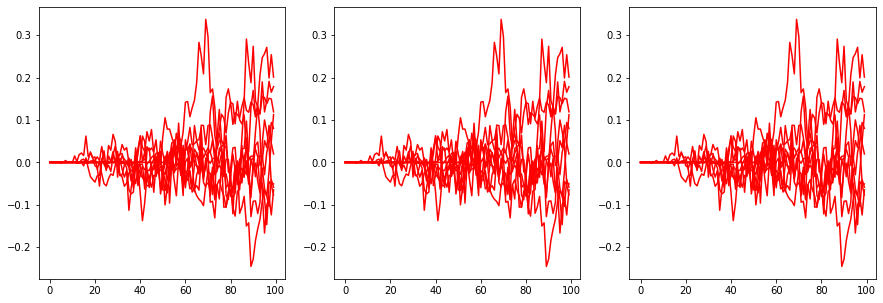

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

H2S = [0.5, 1.0]
I = list(range(1, 6))


for h2s in H2S:
    for i in I:
        df_m = read_csv(f"/home/shussain/gpu_queue/loss_sing2/thr_{h2s}_{i}.csv")
            plt.sca(ax)
            ax.plot(df_m["loss"]-df_s["loss"], color="red")       

No handles with labels found to put in legend.


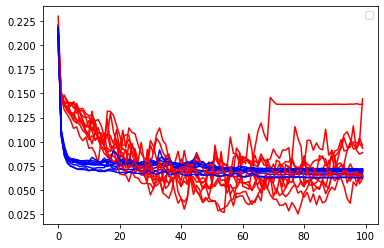

In [69]:
H2S = [0.5, 1.0]
I = list(range(1, 6))



rho = 0.8

for h2s in H2S:
    for i in I:
        df = read_csv(f"/home/shussain/gpu_queue/loss_multi/thr_{h2s}_{i}.csv")
        plt.plot((1-rho) * df["clf_loss"], color="red")
        plt.plot(rho * df["decoder_loss"], color="blue")   
        
plt.legend()

In [ ]:
for rho

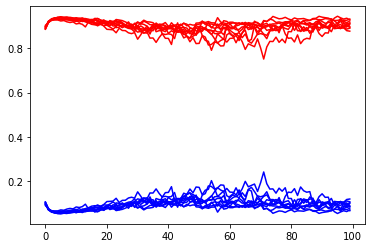

In [53]:
H2S = [0.5, 1.0]
I = list(range(1, 6))


for h2s in H2S:
    for i in I:
        df = read_csv(f"/home/shussain/gpu_queue/loss_sing/thr_{h2s}_{i}.csv")
        plt.plot(0.7*df["clf_loss"]/df["loss"], color="red")
        plt.plot(0.3*df["decoder_loss"]/df["loss"], color="blue")            

In [74]:
rhos = [0, 0.5, 0.83, 0.85, 0.87, 0.9, 0.93, 0.95]
from os import mkdir
H2S = [0.05]
for rho in rhos:
    #mkdir(f"/home/shussain/experiments/different_intervals_chr22/results/rho_{rho}/")
    for h2s in H2S:
        mkdir(f"/home/shussain/experiments/different_intervals_chr22/results/rho_{rho}/h2s_{h2s}")
        for i in range(1, 51):
            mkdir(f"/home/shussain/experiments/different_intervals_chr22/results/rho_{rho}/h2s_{h2s}/sim_{i}")
